In [2]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug.augmentables.batches import Batch
import numpy as np
import matplotlib.pyplot as plt

## Data Augmentation

In order to make the model not overfit on the dataset we need to apply data augmentations techniques.
By default extrayolo supports [imgaug]() as data augmentation framework.
The example below shows an example of image with 2 bounding boxes.


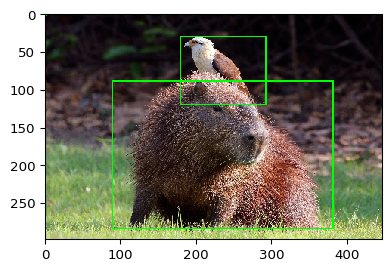

In [3]:
image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/8/8e/Yellow-headed_caracara_%28Milvago_chimachima%29_on_capybara_%28Hydrochoeris_hydrochaeris%29.JPG")
image = ia.imresize_single_image(image, (298, 447))

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=0.2*447, x2=0.85*447, y1=0.3*298, y2=0.95*298),
    BoundingBox(x1=0.4*447, x2=0.65*447, y1=0.1*298, y2=0.4*298),
    BoundingBox(0,0,0,0)
], shape=image.shape)

ia.imshow(bbs.draw_on_image(image, size=2))

In order to perform data augmentation on the image we can create a pipeline of transformations.

In [4]:
pipeline = iaa.Sequential([
    iaa.GammaContrast(1.5), # add contrast
    iaa.Affine(translate_percent={"x": 0.1}, scale=0.8), # translate the image
    iaa.Fliplr(p = 1.0) # apply horizontal flip
])

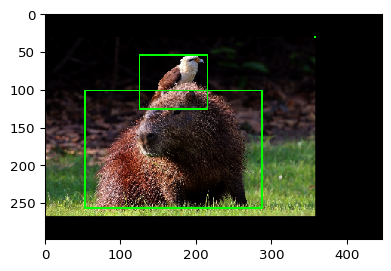

array([[ 53.439987, 101.22    , 285.88    , 256.18    ],
       [124.96001 ,  53.539997, 214.36    , 125.06    ],
       [357.4     ,  29.699999, 357.4     ,  29.699999]], dtype=float32)

In [5]:
image_aug, bbs_aug = pipeline(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))
bbs_aug.to_xyxy_array()

We can see that the images is augmented such as the boxes.
Given a set of transformations they can be applied to a batch of images.
We create a batch of images

In [6]:
images = np.array([image, image])
bbss = [bbs, bbs]
batch = Batch(images=images, bounding_boxes=bbss)

In [7]:
pipeline = iaa.Sequential([
    iaa.GammaContrast(1.5),
    iaa.Affine(rotate=(-90, 90))
])

and perform data augmentation on the batch

In [8]:
batch_processed = pipeline.augment_batch(batch)
batch_processed.images_aug.shape

(2, 298, 447, 3)

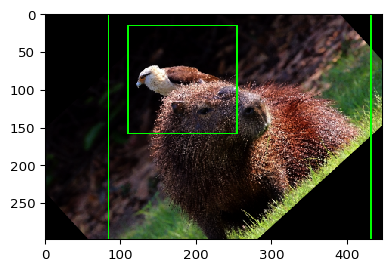

[[ 84.47671     -0.95089597 429.66367    337.98044   ]
 [110.338524    15.286891   253.14641    156.65118   ]
 [-41.822052   189.12672    -41.822052   189.12672   ]]


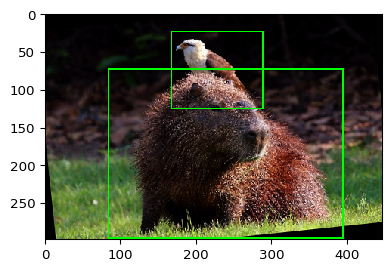

[[ 83.97693   73.39386  393.1003   296.26755 ]
 [166.692     23.417078 287.13556  123.95688 ]
 [-14.237909  24.003315 -14.237909  24.003315]]


In [9]:
for image_aug, bbs_aug in zip(batch_processed.images_aug, batch_processed.bounding_boxes_aug):
    ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))
    print(bbs_aug.to_xyxy_array())

In [10]:
def make_augmentations(max_number_augs=5):
    augmentation = iaa.SomeOf((0, max_number_augs), [
        iaa.GaussianBlur(sigma=(0.0, 3.0)),
        iaa.Affine(scale=(1., 2.5), rotate=(-90, 90), shear=(-16, 16),
                   translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
        iaa.LinearContrast((0.5, 1.5)),
        iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),
        iaa.Alpha((0.0, 1.0), iaa.Grayscale(1.0)),
        iaa.LogContrast(gain=(0.6, 1.4)),
        iaa.PerspectiveTransform(scale=(0.01, 0.15)),
        iaa.Clouds(),
        iaa.Alpha(
            (0.0, 1.0),
            first=iaa.Add(100),
            second=iaa.Multiply(0.2)),
        iaa.MotionBlur(k=5),
        iaa.MultiplyHueAndSaturation((0.5, 1.0), per_channel=True),
        iaa.AddToSaturation((-50, 50)),
        iaa.Noop()
    ])
    return augmentation